# Projet d'intelligence artificielle : reconnaissances de kystes bénins ou malins sur échographies mammaires

#### Par Arthur LASHERMES et Jaden COUCHOT

Bibliothèques et dataset utilisés pour ce projet :

In [395]:
import pandas as pd
import numpy as np
import matplotlib.image as im
import matplotlib.pyplot as plt
import cv2

from os import listdir
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics, svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Lien du dataset : https://www.kaggle.com/aryashah2k/breast-ultrasound-images-dataset

# Chargement des images d'échographies mammaires

Les images sont triées dans des dossiers "benign", "malignant" et "normal"

In [326]:
data = []
i=0;

nbb = 0
nbm = 0
nbn = 0

# La boucle parcourt le répertoire 'Dataset_BUSI_with_GT/' puis tout ces sous-répertoires afin de placer
# les images dans la liste data
for directory in sorted(listdir('Dataset_BUSI_with_GT/')):
    print(directory)
    for img in sorted(listdir('Dataset_BUSI_with_GT/' + directory + '/')):
        #Récupération des images non-masques et incrémentation du nombre d'images contenant dans les trois répertoires
        if ('mask' not in img) :
            if directory == 'benign' : nbb = nbb + 1
            if directory == 'malignant' : nbm = nbm + 1
            if directory == 'normal' : nbn = nbn + 1
            data.append(cv2.imread('Dataset_BUSI_with_GT/' + directory + '/' + img))

benign
malignant
normal


# Vérification du chargement des données

780


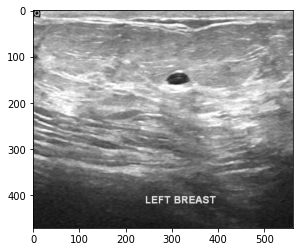

In [327]:
print(len(data))
plt.imshow(data[0])

In [324]:
print('Nombre benin :', nbb, ' --------- rang [ 0 ] à [', nbb-1,']')
print('Nombre malin :', nbm, ' --------- rang [', nbb,'] à [', nbb + nbm-1,']')
print('Nombre normal :', nbn, ' -------- rang [', nbb + nbm,'] à [', nbb + nbm + nbn - 1,']')

Nombre benin : 437  --------- rang [ 0 ] à [ 436 ]
Nombre malin : 210  --------- rang [ 437 ] à [ 646 ]
Nombre normal : 133  -------- rang [ 647 ] à [ 779 ]


# Définition de la cible des données

Création du tableau target grâce aux index précedemment calculés :

In [11]:
target = []

for i in range (780):
    if (i < 437) : target.append('benign')
    if (i > 436) and (i<647) : target.append('malignant')
    if (i > 646): target.append('normal')


# Conversion des images en niveau de gris

In [329]:
# Cette fonction permet la conversion 
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2125, 0.7154, 0.0721])

datagray = []
for i in range (780):
    datagray.append(rgb2gray(data[i]))

Vérification de la conversion

780
(471, 562)


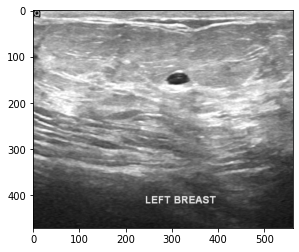

In [333]:
print(len(datagray))
print(datagray[0].shape)
plt.imshow(datagray[0], cmap='gray')

##### Redimension des images :

Les images ont été redimensionnées en taille 64 par 64

In [134]:
dataresized = []

def resizeimage(img) :
    return cv2.resize(img,(64, 64), interpolation = cv2.INTER_AREA)

for i in range (780):
    dataresized.append(resizeimage(datagray[i]))

La liste datatrain ci-dessous contient les données sous forme d'un tableau à une dimension grâce à la fonction ravel de numpy

In [15]:
datatrain = []

for i in range (780):
    datatrain.append(np.ravel(dataresized[i]))

Vérification du ravel :

In [16]:
print(len(datatrain))
print(datatrain[1].shape)

780
(4096,)


# Préparation pour l'apprentissage

In [443]:
# Préparation des données d'apprentissage
X = np.array(datatrain)

# Préparation des données cibles
Y = np.array(target)

print(X.shape)
print(Y.shape)

# Formation des bases d'apprentissage et de test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y,test_size=0.25, random_state=0)

(780, 4096)
(780,)


# Test de la meilleure méthode pour la classification 

## Classification avec l'abre de décision

In [444]:
Arbre_decision = DecisionTreeClassifier(random_state=0, max_depth=2)
clftest1 = Arbre_decision.fit(Xtrain, ytrain)
ypredit = clftest1.predict(Xtest)

print('Pourcentage de précision : ', accuracy_score(ytest, ypredit), '%')

Pourcentage de précision :  0.6153846153846154 %


## Fonction pour l'affichage de la matrice de confusion

Cette fonction permet l'affichage de la matrice de confusion ainsi que sa représentation graphique

In [445]:
def plot_confusion_matrix(cmx, vmax1=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=1)
    fig.set_size_inches(12, 3)
    ax.set_xticks(range(len(cmx)+1))
    ax.set_yticks(range(len(cmx)+1))
    
    print(cmx)
    
    ax.set_title('Réprésentation du % de précision par type de cellule')
    im1 = ax.imshow(cmx_norm, vmax=vmax1)
    
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.1)
 
    fig.colorbar(im1, cax=cax1)
    fig.tight_layout()

[[92 22  0]
 [21 28  0]
 [28  4  0]]


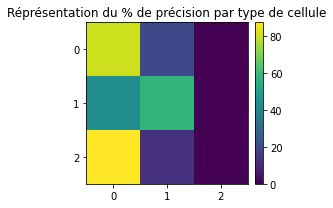

In [446]:
plot_confusion_matrix(metrics.confusion_matrix(ytest, ypredit))

## Classification avec le plus proche voisin

In [447]:
KNN = KNeighborsClassifier()
clftest2 = KNN .fit(Xtrain, ytrain)

ypredit = clftest2.predict(Xtest)
print('Pourcentage de précision : ', accuracy_score(ytest, ypredit), '%')

Pourcentage de précision :  0.5948717948717949 %


[[76 10 28]
 [17 29  3]
 [18  3 11]]


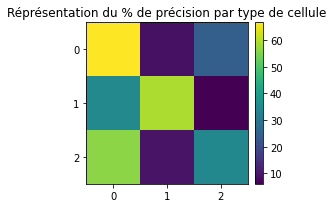

In [448]:
plot_confusion_matrix(metrics.confusion_matrix(ytest, ypredit))

## Classification avec SVM

In [460]:
clf = svm.SVC(C=10, gamma=0.0000003)
clf.fit(Xtrain,ytrain)

SVC(C=10, gamma=3e-07)

In [461]:
ypredit = clf.predict(Xtest)
print('Pourcentage de précision : ', accuracy_score(ytest, ypredit), '%')

Pourcentage de précision :  0.7948717948717948 %


Le pourcentage obtenu ci-dessus est le plus haut pourcentage obtenu en modifiant les paramètres sans vraie méthode

[[108   5   1]
 [ 16  32   1]
 [ 17   0  15]]


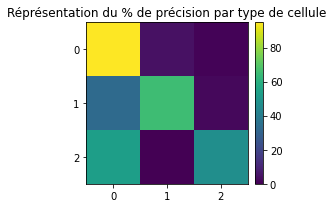

In [462]:
plot_confusion_matrix(metrics.confusion_matrix(ytest, ypredit))

# Recherche exhaustive des meilleurs paramètres à l'aide des méthodes de GridSearchCV

In [396]:
# Définition de la grillle de paramètres à tester
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.0000003],
              'kernel': ['rbf']}
 
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
 
# Raccordement du modèle pour la grid search
grid.fit(Xtrain, ytrain)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.547 total time=   0.4s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.547 total time=   0.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.556 total time=   0.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.556 total time=   0.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.556 total time=   0.4s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.547 total time=   0.4s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.547 total time=   0.4s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.556 total time=   0.4s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.556 total time=   0.4s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.556 total time=   0.4s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.547 total time=   0.4s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .....C=10, gamma=3e-07, kernel=rbf;, score=0.709 total time=   0.4s
[CV 3/5] END .....C=10, gamma=3e-07, kernel=rbf;, score=0.744 total time=   0.4s
[CV 4/5] END .....C=10, gamma=3e-07, kernel=rbf;, score=0.701 total time=   0.4s
[CV 5/5] END .....C=10, gamma=3e-07, kernel=rbf;, score=0.752 total time=   0.4s
[CV 1/5] END ........C=100, gamma=1, kernel=rbf;, score=0.547 total time=   0.4s
[CV 2/5] END ........C=100, gamma=1, kernel=rbf;, score=0.547 total time=   0.4s
[CV 3/5] END ........C=100, gamma=1, kernel=rbf;, score=0.556 total time=   0.4s
[CV 4/5] END ........C=100, gamma=1, kernel=rbf;, score=0.547 total time=   0.4s
[CV 5/5] END ........C=100, gamma=1, kernel=rbf;, score=0.556 total time=   0.4s
[CV 1/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.547 total time=   0.4s
[CV 2/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.547 total time=   0.4s
[CV 3/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.556 total time=   0.4s
[CV 4/5] END ......C=100, ga

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 3e-07],
                         'kernel': ['rbf']},
             verbose=3)

In [397]:
# Meilleures paramètres obtenus
print(grid.best_params_)

# Paramètres à modifier sur la méthode SVC
print(grid.best_estimator_)

{'C': 10, 'gamma': 3e-07, 'kernel': 'rbf'}
SVC(C=10, gamma=3e-07)


In [398]:
grid_predictions = grid.predict(Xtest)
 
# Affichage des pourcentages de réussites obtenus après la recherche
print(classification_report(ytest, grid_predictions))

              precision    recall  f1-score   support

      benign       0.77      0.95      0.85       114
   malignant       0.86      0.65      0.74        49
      normal       0.88      0.47      0.61        32

    accuracy                           0.79       195
   macro avg       0.84      0.69      0.73       195
weighted avg       0.81      0.79      0.78       195



Nous avons donc modifié les paramètres afin d'obtenir le meilleur pourcentage de précision avec la méthode SVC

# Classification grâce aux masques d'images d'échographies mamaires

## Chargement des données de masque

Même principe que la première fois mais condition inverse

In [401]:
masks = []
i=0;

mnbb = 0
mnbm = 0
mnbn = 0

for directory in sorted(listdir('Dataset_BUSI_with_GT/')):
    print(directory)
    for img in sorted(listdir('Dataset_BUSI_with_GT/' + directory + '/')):
        if ('mask' in img) :
            masks.append(cv2.imread('Dataset_BUSI_with_GT/' + directory + '/' + img))
            if directory == 'benign' : mnbb = mnbb + 1
            if directory == 'malignant' : mnbm = mnbm + 1
            if directory == 'normal' : mnbn = mnbn + 1

benign
malignant
normal


In [400]:
print('Nombre benin :', mnbb, ' --------- rang [ 0 ] à [', mnbb-1,']')
print('Nombre malin :', mnbm, ' --------- rang [', mnbb,'] à [', mnbb + mnbm-1,']')
print('Nombre normal :', mnbn, ' -------- rang [', mnbb + mnbm,'] à [', mnbb + mnbm + mnbn - 1,']')

Nombre benin : 454  --------- rang [ 0 ] à [ 453 ]
Nombre malin : 211  --------- rang [ 454 ] à [ 664 ]
Nombre normal : 133  -------- rang [ 665 ] à [ 797 ]


# Définition de la cible des données

Création du tableau targetmasks grâce aux index précedemment calculés :

In [178]:
targetmasks = []

for i in range (798):
    if (i < 454) : targetmasks.append('benign')
    if (i > 453) and (i<666) : targetmasks.append('malignant')
    if (i > 665): targetmasks.append('normal')

In [402]:
print(len(masks))
print(len(targetmasks))

798
798


# Conversion des masques et redimensionnement (même principe que précédemment)

In [403]:
datagraymasks = []
for i in range (798):
    datagraymasks.append(rgb2gray(masks[i]))

In [404]:
datamasksresized = []

for i in range (798):
    datamasksresized.append(resizeimage(datagraymasks[i]))

In [405]:
datamaskstrain = []

for i in range (798):
    datamaskstrain.append(np.ravel(datamasksresized[i]))

# Préparation pour l'apprentissage

In [406]:
X = np.array(datamaskstrain)
Y = np.array(targetmasks)

print(X.shape)
print(Y.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y,test_size=0.25, random_state=0)

(798, 4096)
(798,)


## Classification avec l'abre de décision

In [428]:
Arbre_decision = DecisionTreeClassifier(random_state=0, max_depth=2)
clfmtest1 = Arbre_decision.fit(Xtrain, ytrain)
ypredit = clfmtest1.predict(Xtest)

print('Pourcentage de précision : ', accuracy_score(ytest, ypredit), '%')

Pourcentage de précision :  0.6 %


[[100  12   0]
 [ 36  20   0]
 [ 32   0   0]]


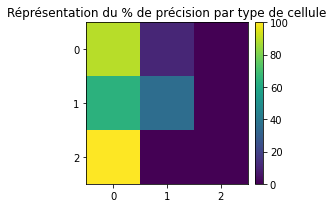

In [429]:
plot_confusion_matrix(metrics.confusion_matrix(ytest, ypredit))

## Classification avec le plus proche voisin

In [430]:
KNN = KNeighborsClassifier()
clfmtest2 = KNN .fit(Xtrain, ytrain)

ypredit = clfmtest2.predict(Xtest)
print('Pourcentage de précision : ', accuracy_score(ytest, ypredit), '%')

Pourcentage de précision :  0.705 %


[[86  7 19]
 [31 23  2]
 [ 0  0 32]]


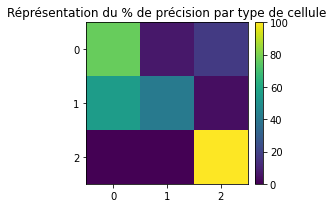

In [431]:
plot_confusion_matrix(metrics.confusion_matrix(ytest, ypredit))

## Classification avec SVM

In [432]:
clfm = svm.SVC(gamma=0.0000001)
clfm.fit(Xtrain,ytrain)

SVC(gamma=1e-07)

In [433]:
ypredit = clfm.predict(Xtest)
print('Pourcentage de précision : ', accuracy_score(ytest, ypredit), '%')

Pourcentage de précision :  0.835 %


[[98  9  5]
 [18 37  1]
 [ 0  0 32]]


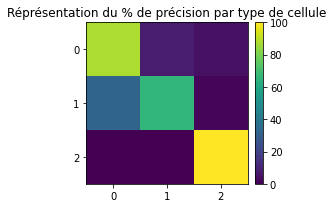

In [434]:
plot_confusion_matrix(metrics.confusion_matrix(ytest, ypredit))

# Recherche exhaustive des meilleurs paramètres à l'aide des méthodes de GridSearchCV

In [414]:
# Définition de la grillle de paramètres à tester
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.0000003],
              'kernel': ['rbf']}
 
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
 
# Raccordement du modèle pour la grid search
grid.fit(Xtrain, ytrain)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.742 total time=   0.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.742 total time=   0.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.733 total time=   0.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.739 total time=   0.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.739 total time=   0.4s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.742 total time=   0.5s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.742 total time=   0.4s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.733 total time=   0.5s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.739 total time=   0.4s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.739 total time=   0.4s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.742 total time=   0.4s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .....C=10, gamma=3e-07, kernel=rbf;, score=0.817 total time=   0.3s
[CV 3/5] END .....C=10, gamma=3e-07, kernel=rbf;, score=0.775 total time=   0.3s
[CV 4/5] END .....C=10, gamma=3e-07, kernel=rbf;, score=0.731 total time=   0.3s
[CV 5/5] END .....C=10, gamma=3e-07, kernel=rbf;, score=0.765 total time=   0.3s
[CV 1/5] END ........C=100, gamma=1, kernel=rbf;, score=0.742 total time=   0.4s
[CV 2/5] END ........C=100, gamma=1, kernel=rbf;, score=0.742 total time=   0.4s
[CV 3/5] END ........C=100, gamma=1, kernel=rbf;, score=0.733 total time=   0.4s
[CV 4/5] END ........C=100, gamma=1, kernel=rbf;, score=0.739 total time=   0.4s
[CV 5/5] END ........C=100, gamma=1, kernel=rbf;, score=0.739 total time=   0.4s
[CV 1/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.742 total time=   0.4s
[CV 2/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.742 total time=   0.4s
[CV 3/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.733 total time=   0.4s
[CV 4/5] END ......C=100, ga

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 3e-07],
                         'kernel': ['rbf']},
             verbose=3)

In [415]:
# Meilleures paramètres obtenus
print(grid.best_params_)

# Paramètres à modifier sur la méthode SVC
print(grid.best_estimator_)

{'C': 10, 'gamma': 3e-07, 'kernel': 'rbf'}
SVC(C=10, gamma=3e-07)


In [416]:
grid_predictions = grid.predict(Xtest)
 
# Affichage des pourcentages de réussites obtenus après la recherche
print(classification_report(ytest, grid_predictions))

              precision    recall  f1-score   support

      benign       0.85      0.88      0.86       112
   malignant       0.74      0.66      0.70        56
      normal       0.97      1.00      0.98        32

    accuracy                           0.84       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.84      0.84      0.84       200



## Test de classification de 6 images : échographies mammaire benigne, maligne et normal

Une fois le modèle entraîné, nous allons tester la classification sur 6 images (3 échographies et leur masque correspondant)

In [454]:
image = []
imagemasks = []
allimages = []

# Tri des images dans des listes différentes afin d'utiliser le modèle correspondant
for img in sorted(listdir('ImageTest/')):
        if ('mask' not in img) :
            image.append(cv2.imread('ImageTest/' + img))
        else :
            imagemasks.append(cv2.imread('ImageTest/' + img))

# Liste contenant successivement les images et leur masque
for i in range (3) :
    allimages.append(image[i])
    allimages.append(imagemasks[i])

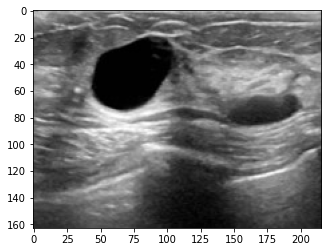

In [455]:
plt.imshow(image[0])

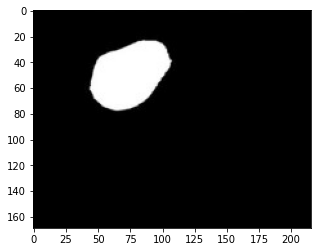

In [456]:
plt.imshow(imagemasks[0])

# Classification des images grâce au modèle correspondant (masque ou échographie)

In [463]:
imagegrey = []
imageresized = []
prediction = []

for i in range (3) :
    imagegrey = rgb2gray(image[i])
    imageresized = resizeimage(imagegrey)
    prediction.append(clf.predict(imageresized.reshape(1,-1))[0])
    imagegrey = rgb2gray(imagemasks[i])
    imageresized = resizeimage(imagegrey)
    prediction.append(clfm.predict(imageresized.reshape(1,-1))[0])

In [464]:
print(prediction)

['benign', 'benign', 'malignant', 'malignant', 'normal', 'normal']


Les prédictions ci-dessus correspondent bien à ce qui était attendu (une image et son masque à la suite)

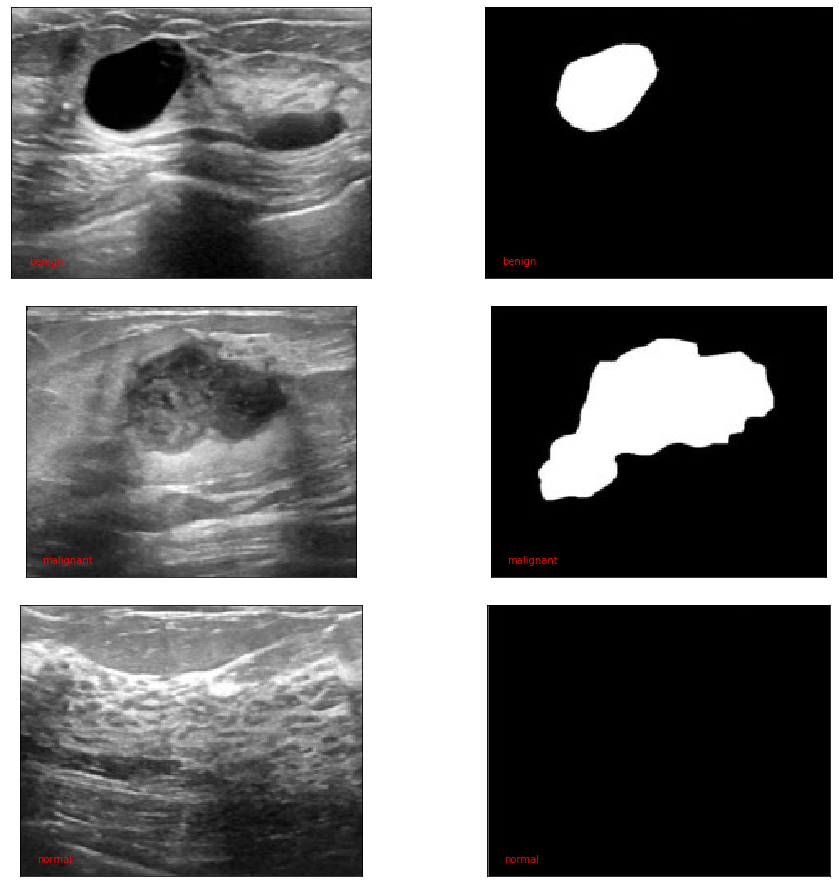

In [465]:
fig, axes = plt.subplots(3, 2, figsize=(16, 16),
                         subplot_kw={ 'xticks':[], 'yticks':[] },
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(allimages[i], cmap='gray', interpolation='nearest')
    ax.text(0.05, 0.05, str(prediction[i]),transform=ax.transAxes, color='red')